# Research Design Diagnosis Starting Point - Binary Outcomes
J. Nathan Matias ([natematias.com](https://natematias.com)) ([@natematias](https://twitter.com/natematias))
February 2020

Materials related to the Design Diagnosis Assignment in the 2020 edition of [COMM 4940](https://natematias.com/courses/comm4940/syllabus.html).

In [2]:
options("scipen"=9, "digits"=4)
library(ggplot2)        # for plotting 
library(rlang)
library(tidyverse)
library(viridis)        # colorblind safe palettes
library(DeclareDesign)
library(beepr)
## Installed DeclareDesign 0.13 using the following command:
# install.packages("DeclareDesign", dependencies = TRUE,
#                 repos = c("http://R.declaredesign.org", "https://cloud.r-project.org"))

## DOCUMENTATION AT: https://cran.r-project.org/web/packages/DeclareDesign/DeclareDesign.pdf
cbPalette <- c("#999999", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7")
options(repr.plot.width=7, repr.plot.height=3.5)
#sessionInfo()

# Configuration

In [1]:
example.config <- data.frame(
    pa.label = "example.design",
    n.max = 2000,
    n.min = 250,

    ACT.ctl      = 0.05,  ## the control group probability of taking an action 
    ACT.effect.a = 0.05   ## the increase in the probability of taking action A
)

### Utility Methods

In [40]:
# Return the minimum power reported in a diagnosis
# 
#` @param diagnosis
min.diagnosis.power <- function(diagnosis){
    min(diagnosis$diagnosands_df['power'])
}

# Iterate linearly for a certain level of statistical power
# within the constraints of a configuration file
# at a certain sample size increment. Useful for
# illustrating ideas, or for comparing estimators with
# very different statistical power, where the binary search
# will optimize for the worst estimator but not show useful
# indormation about more efficient estimators
#
#` @param config.df The configuration file in question
#` @diagnosis.method The method that conducts a single DeclareDesign diagnosis and returns the diagnosis
#` @iteration.interval when iterating, use this interval between sample sizes

iterate.for.power <- function(config.df, diagnosis.method = diagnose.experiment, 
                             iteration.interval){  
    max.sample.size = config.df$n.max
    min.sample.size = config.df$n.min
    current.sample.size = min.sample.size
    
    iteration.count = ceiling((max.sample.size - min.sample.size) / iteration.interval)

    ## Initialize first iteration
    print(paste("min:", min.sample.size, "max:", max.sample.size, "current:", current.sample.size))
    flush.console()

    ptm = proc.time()
    ddf <- diagnosis.method(current.sample.size, config.df)
    ddf$diagnosands$n <- current.sample.size
    diagnoses.df = ddf$diagnosands
    current.power <- min.diagnosis.power(ddf)
    time.elapsed <- proc.time() -  ptm
    print(paste("     seconds:", as.integer(time.elapsed['elapsed'])))
    
    for(i in seq(1, iteration.count)){
        current.sample.size = current.sample.size + iteration.interval
        print(paste("min:", min.sample.size, "max:", max.sample.size, "current:", current.sample.size))
        flush.console()
    
        ptm = proc.time()
        ## conduct simulations
        ddf <- diagnosis.method(current.sample.size, config.df)
        ddf$diagnosands$n <- current.sample.size
        ## append simulation results to dataframe
        diagnoses.df <- rbind(diagnoses.df, ddf$diagnosands)
        time.elapsed <- proc.time() -  ptm
        print(paste("     seconds:", as.integer(time.elapsed['elapsed'])))
    }
    diagnoses.df
}

# Create a plot of a power search or iteration output
# And save to a file
# Especially useful in cases with multiple DVs or models
#
#` @param diagnoses Dataframe of diagnosis info
#` @param config.df the power analysis config dataframe

plot.power.results <- function(diagnoses, config.df){
    for(estimator_label in unique(diagnoses$estimator_label)){
        estimator.diagnoses <- diagnoses[diagnoses$estimator_label==estimator_label,]
        estimator_min_sample = min(estimator.diagnoses$n[estimator.diagnoses$power>0.8])
        p <- ggplot(data=estimator.diagnoses, aes(n, power)) +
                geom_point(color="coral") +
                xlab("sample size") +
                ylim(0,1) +
                geom_hline(aes(yintercept=0.8), linetype="dashed") +
                theme_light() +
                ggtitle(paste(config.df$pa.label, ": statistical Power for Estimator ", estimator_label, "\n",
                              "Minimum sample: ", estimator_min_sample, sep="")) +
                ggsave(paste("figures/power.analysis.", make.names(estimator_label), ".", config.df$pa.label, ".png", sep=""))
    }
}

### Method for diagnosing an experiment

In [53]:
diagnose.experiment  <- function( n.size, cdf, sims.count = 500, bootstrap.sims.count = 500){
    design <-   declare_population(N = n.size) +
            declare_potential_outcomes(
                ACT_Z_0 = rbinom(N, 1, cdf$ACT.ctl),
                ACT_Z_1 = rbinom(N, 1, cdf$ACT.ctl + cdf$ACT.effect.a)
            ) +
            declare_assignment(num_arms = 2,
                               conditions = c("0", "1"),
                               assignment_variable = Z) +
        
            ## ESTIMANDS FOR LOGISTIC REGRESSION (PROPORTIONS / MEANS)
            declare_estimand(ate_ACT_mean_1_0  = cdf$ACT.effect.a) +

            ## REVEAL
            declare_reveal(outcome_variables = c("ACT"), assignment_variables = c("Z")) +
            

            ##
            ## ESTIMATORS FOR ACT (OLS regression)
            ## The reason I have written these custom handlers is that DeclareDesign's
            ## difference in means estimator has problems with cases where there is no 
            ## difference at all, and where all outcome variables are zero. In that case
            ## I set the p value to 1 in order to successfully diagnose the design
            ## 
            declare_estimator(label = "ACT_na_handling_mean_1_0", estimand="ate_ACT_mean_1_0",
                              handler=tidy_estimator(function(data){
                                  m <- lm(formula= ACT ~ Z, data, subset = (Z %in% c(0,1)))

                                  out <- subset(tidy(m), term == "Z1")
                                  if(m$coefficients['Z1'] == 0){
                                      out$p.value = 1
                                  }                                  
                                  transform(out,
                                      conf.low = estimate - 1.96*std.error,
                                      conf.high = estimate + 1.96*std.error
                                  )
                              })) 

     diagnosis <- diagnose_design(design, sims = sims.count, 
                                  bootstrap_sims = bootstrap.sims.count)
     diagnosis
}

# Conduct Power Analysis

In [54]:
interval = 250
power.iterate.df <- iterate.for.power(example.config, 
                                      diagnosis.method=diagnose.experiment, 
                                      iteration.interval = interval)
beep(sound="treasure")

[1] "min: 250 max: 2000 current: 250"
[1] "     seconds: 7"
[1] "min: 250 max: 2000 current: 500"
[1] "     seconds: 7"
[1] "min: 250 max: 2000 current: 750"
[1] "     seconds: 7"
[1] "min: 250 max: 2000 current: 1000"
[1] "     seconds: 7"
[1] "min: 250 max: 2000 current: 1250"
[1] "     seconds: 7"
[1] "min: 250 max: 2000 current: 1500"
[1] "     seconds: 9"
[1] "min: 250 max: 2000 current: 1750"
[1] "     seconds: 9"
[1] "min: 250 max: 2000 current: 2000"
[1] "     seconds: 7"


# Plot the Chance of Observing a Statistically-Significant Effect for Different Sample Sizes

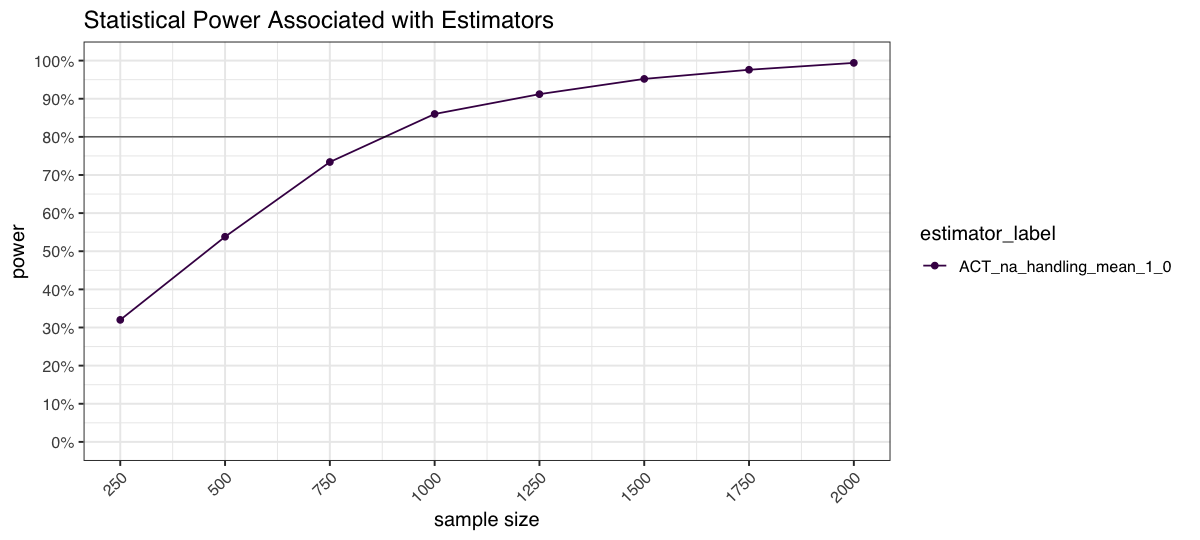

In [55]:
options(repr.plot.width=10, repr.plot.height=4.5)

ggplot(power.iterate.df, aes(n, power, color=estimator_label)) +
    ## CHART SUBSTANCE
    geom_line() +
    geom_point() +
    ## LABELS AND COSMETICS
    geom_hline(yintercept=0.8, size=0.25) +
    theme_bw(base_size = 12, base_family = "Helvetica") +
    theme(axis.text.x = element_text(angle=45, hjust = 1)) +
    scale_y_continuous(breaks = seq(0,1,0.1), limits = c(0,1), labels=scales::percent) +
    scale_x_continuous(breaks = seq(example.config$n.min,example.config$n.max,interval)) +
    scale_color_viridis(discrete=TRUE) +
    xlab("sample size") +
    ggtitle("Statistical Power Associated with Estimators")

In [47]:
# ggplot(power.iterate.df, aes(n, bias, color=estimator_label)) +
#     ## CHART SUBSTANCE
#     geom_line() +
#     geom_jitter(width=20, height=0) +
#     ## LABELS AND COSMETICS
#     theme_bw(base_size = 12, base_family = "Helvetica") +
#     theme(axis.text.x = element_text(angle=45, hjust = 1)) +
#     scale_x_continuous(breaks = seq(example.config$n.min,example.config$n.max,interval)) +
#     scale_color_viridis(discrete=TRUE) +
#     xlab("sample size") +
#     ggtitle("Mean Bias Associated with Estimators")

In [48]:
# ggplot(power.iterate.df, aes(n, coverage, color=estimator_label)) +
#     ## CHART SUBSTANCE
#     geom_line() +
#     geom_point() +
#     ## LABELS AND COSMETICS
#     theme_bw(base_size = 12, base_family = "Helvetica") +
#     theme(axis.text.x = element_text(angle=45, hjust = 1)) +
#     scale_x_continuous(breaks = seq(example.config$n.min,example.config$n.max,interval)) +
#     scale_y_continuous(breaks = seq(0,1,0.1), limits = c(0,1), labels=scales::percent) +
#     scale_color_viridis(discrete=TRUE) +
#     xlab("sample size") +
#     ggtitle("Mean Confidence Interval Coverage Associated with Estimators")

In [49]:
# ggplot(power.iterate.df, aes(n, type_s_rate, color=estimator_label)) +
#     ## CHART SUBSTANCE
#     geom_line() +
#     geom_point() +
#     ## LABELS AND COSMETICS
#     theme_bw(base_size = 12, base_family = "Helvetica") +
#     theme(axis.text.x = element_text(angle=45, hjust = 1)) +
#     scale_x_continuous(breaks = seq(example.config$n.min,example.config$n.max,interval)) +
#     scale_color_viridis(discrete=TRUE) +
#     xlab("sample size") +
#     ggtitle("Incorrect Sign of Estimate Associated with Estimators")